<a href="https://colab.research.google.com/github/VivoSorhie/RFM-Customer_Segmentation/blob/main/Retail_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online Retail: RFM Customer Segmentation for Marketing Strategy

**Objective:** To analyze a transnational retail dataset to segment customers based on their purchasing behavior (Recency, Frequency, Monetary value) and identify key customer cohorts for targeted marketing campaigns.

In [ ]:
# --- Core Libraries for Data Handling & Analysis ---
import pandas as pd
import numpy as np
import datetime as dt

# --- Libraries for Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Library for Clustering ---
from sklearn.cluster import KMeans

# --- Colab Specific for File Handling ---
from google.colab import files
import io

# --- Settings for a professional look ---
# Ignore warnings to keep the output clean
import warnings
warnings.filterwarnings('ignore')
# Set a default style and color palette for all our plots
sns.set_style('whitegrid')
# Define a custom color palette for our charts (e.g., a nice blue, pink, green)
custom_palette = ['#66b3ff', '#ff9999', '#99ff99', '#ffcc99']
sns.set_palette(custom_palette)

print("All libraries imported and settings applied successfully!")

All libraries imported and settings applied successfully!


In [ ]:
# --- 1. Upload the data ---
print("Please upload your retail dataset CSV file.")
uploaded = files.upload()
print("\nFile upload complete!")

# --- 2. Load and Inspect ---
# Get the name of the uploaded file
file_name = next(iter(uploaded))

# Attempt to read the CSV with a common encoding for this dataset
try:
    df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding='ISO-8859-1')
    print("\nDataFrame loaded successfully!")
    print("\n--- First 5 Rows ---")
    print(df.head())
    print("\n--- Data Info ---")
    df.info()
    print("\n--- Statistical Summary ---")
    print(df.describe())
except Exception as e:
    print(f"Error loading file: {e}")

Please upload your retail dataset CSV file.


Saving online_retail.csv to online_retail.csv

File upload complete!

DataFrame loaded successfully!

--- First 5 Rows ---
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
Ran

# 2. Data Cleaning & Preprocessing

* **Objective:** To transform the raw data into a clean, analysis-ready format.
* **Key Actions:**
    1.  Drop rows with missing `CustomerID`s.
    2.  Remove non-positive `Quantity` (returns) and `UnitPrice` (data errors).
    3.  Convert data types and create a `Revenue` column.

In [ ]:
# --- Create a copy to preserve the original dataframe ---
df_clean = df.copy()
print(f"Original dataset rows: {df_clean.shape[0]}")

# --- 1. Drop rows with missing CustomerID ---
df_clean.dropna(subset=['CustomerID'], inplace=True)
print(f"Rows after dropping null CustomerIDs: {df_clean.shape[0]}")

# --- 2. Remove returns and invalid transactions ---
# Keep only rows with positive Quantity
df_clean = df_clean[df_clean['Quantity'] > 0]
# Keep only rows with positive UnitPrice
df_clean = df_clean[df_clean['UnitPrice'] > 0]
print(f"Rows after removing returns and invalid prices: {df_clean.shape[0]}")

# --- 3. Convert data types ---
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
print("\nConverted 'InvoiceDate' and 'CustomerID' to correct types.")

# --- 4. Create Revenue column ---
df_clean['Revenue'] = df_clean['Quantity'] * df_clean['UnitPrice']
print("Created 'Revenue' column.")

# --- Final Verification ---
print("\n--- Final Cleaned DataFrame Info ---")
df_clean.info()

print("\n--- First 5 Rows of Final Cleaned Data ---")
print(df_clean.head())

Original dataset rows: 541909
Rows after dropping null CustomerIDs: 406829
Rows after removing returns and invalid prices: 397884

Converted 'InvoiceDate' and 'CustomerID' to correct types.
Created 'Revenue' column.

--- Final Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
 8   Revenue      397884 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.4+ MB

--- Firs

#**Exploratory Data Analysis**

* **Objective:** To deeply understand the business by exploring sales trends, customer behavior, and product performance.
* **First Analysis:** What is the overall monthly revenue trend?

## **Visualizing Total Monthly Revenue**
**Action**: We will group our transaction data by month to calculate the total monthly revenue. We will then visualize this as a line chart to see the trend over time.

**Reason**: This is the most important high-level chart for any retail business. It tells us if the business is growing, shrinking, or stagnating, and reveals key seasonal peaks (like the holiday season).

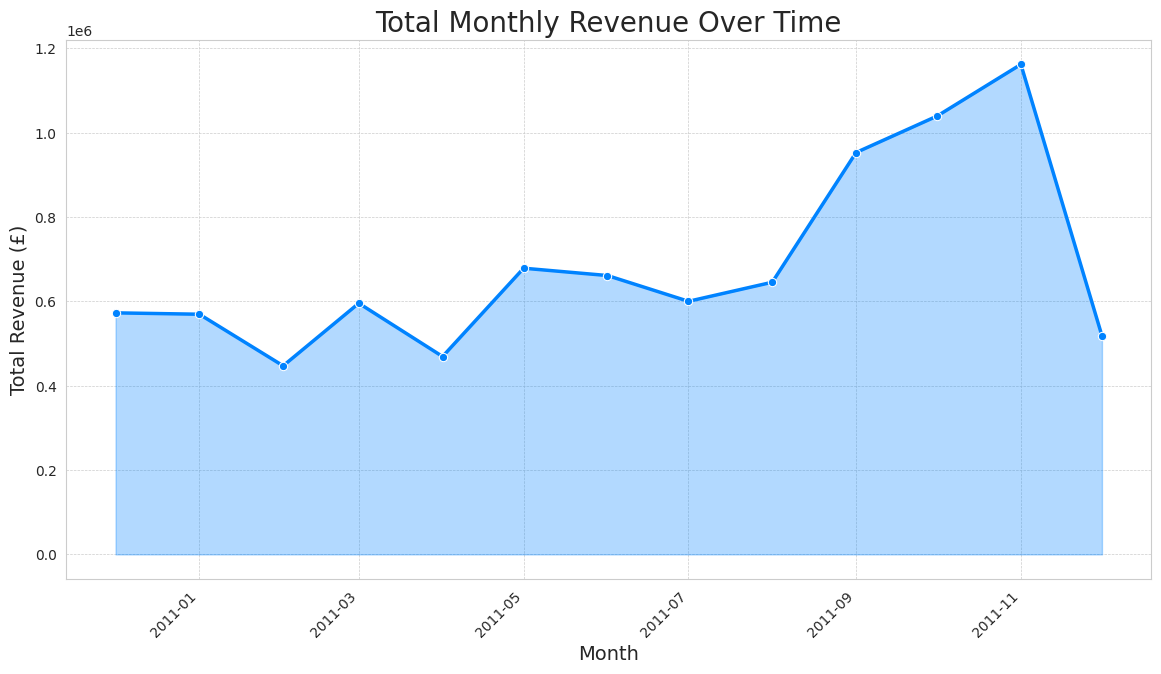

In [ ]:
# --- Calculate Monthly Revenue (if not already done) ---
# This part is the same as before
df_clean['YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M')
monthly_revenue = df_clean.groupby('YearMonth')['Revenue'].sum().reset_index()
monthly_revenue['YearMonth'] = monthly_revenue['YearMonth'].dt.to_timestamp()


# --- Visualize the Monthly Revenue Trend as an Area Chart ---
plt.figure(figsize=(14, 7))

# First, plot the line with markers
sns.lineplot(
    x='YearMonth',
    y='Revenue',
    data=monthly_revenue,
    marker='o',
    color='#0083FF', # The main line color
    linewidth=2.5
)

# We use plt.fill_between to fill the area under the line
plt.fill_between(
    x=monthly_revenue['YearMonth'],
    y1=monthly_revenue['Revenue'],
    color='#0083FF', # Use the same color
    alpha=0.3       # Make it semi-transparent for a lighter shade
)


# --- Style the plot ---
plt.title('Total Monthly Revenue Over Time', fontsize=20)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Revenue (£)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

* **Insight:** The revenue trend shows strong growth and a clear seasonal pattern.
* **Key Findings from the Chart:**
    1.  **Strong Holiday Season:** Revenue spikes dramatically in November, confirming that the pre-Christmas period is the most critical time for the business.
    2.  **Growth in the Second Half:** The company shows a healthy growth trend from August to the November peak.
    3.  **Incomplete December Data:** The sharp drop in December is because the dataset ends on Dec 9th. It is not a full month and should be interpreted with caution.

## **Analyzing Monthly Active Customers**
**Action**: We will group our data by month again, but this time we will count the number of unique CustomerIDs.

**Reason**: This chart will show us the growth of our active customer base over time. We can then compare this to the revenue chart to see if the trends align.

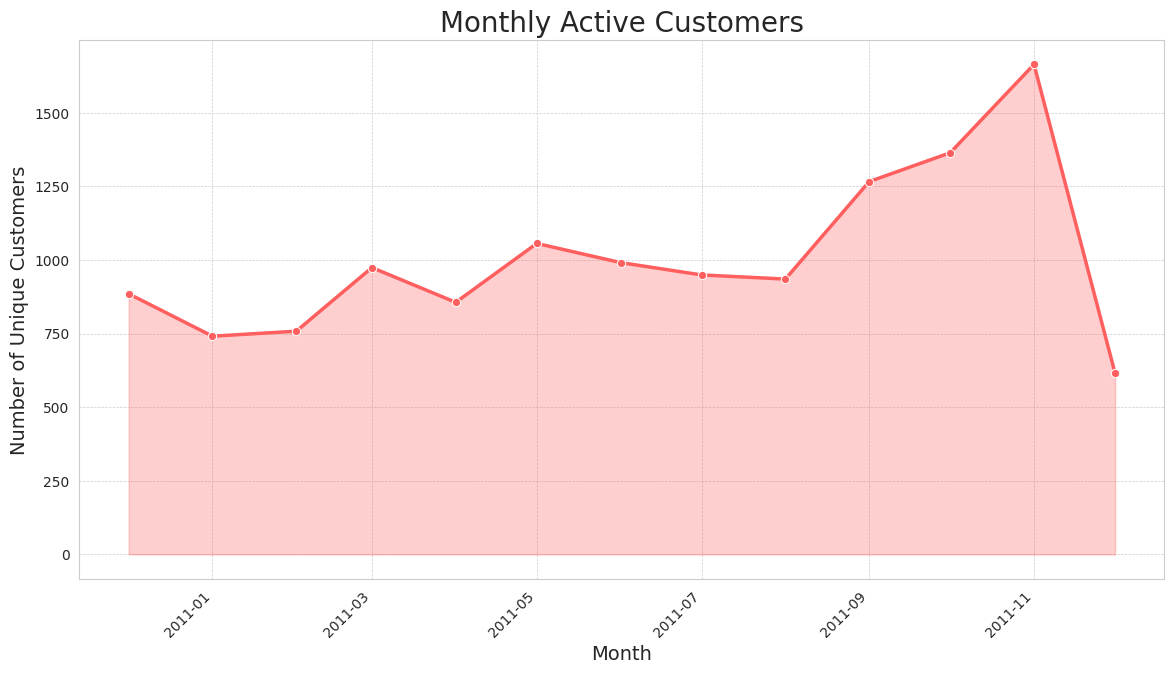

In [ ]:
# --- Calculate Monthly Active Customers (if not already done) ---
monthly_active_customers = df_clean.groupby('YearMonth')['CustomerID'].nunique().reset_index()
monthly_active_customers['YearMonth'] = monthly_active_customers['YearMonth'].dt.to_timestamp()


# --- Visualize the Monthly Active Customer Trend as an Area Chart ---
plt.figure(figsize=(14, 7))

# First, plot the line with markers
sns.lineplot(
    x='YearMonth',
    y='CustomerID',
    data=monthly_active_customers,
    marker='o',
    color='#FF5F5F', # The main line color (pink/coral)
    linewidth=2.5
)

# --- THE NEW STEP: Add the shaded area ---
plt.fill_between(
    x=monthly_active_customers['YearMonth'],
    y1=monthly_active_customers['CustomerID'],
    color='#FF5F5F', # Use the same color
    alpha=0.3       # Make it semi-transparent for a lighter shade
)


# --- Style the plot ---
plt.title('Monthly Active Customers', fontsize=20)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Unique Customers', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

* **Insight:** The trend of active customers almost perfectly mirrors the revenue trend.
* **Key Finding:** This strong correlation indicates that revenue growth is primarily driven by **customer acquisition and activation**. The business is successfully attracting more shoppers during its peak seasons, not just increasing the spend of existing ones.

### **Analyzing Monthly Order Count**
**Action**: We will group the data by month and count the number of unique InvoiceNos.

**Reason**: This will tell us the trend in transaction volume. Comparing this to our previous two charts will give us a complete picture of the business's key performance indicators (KPIs).

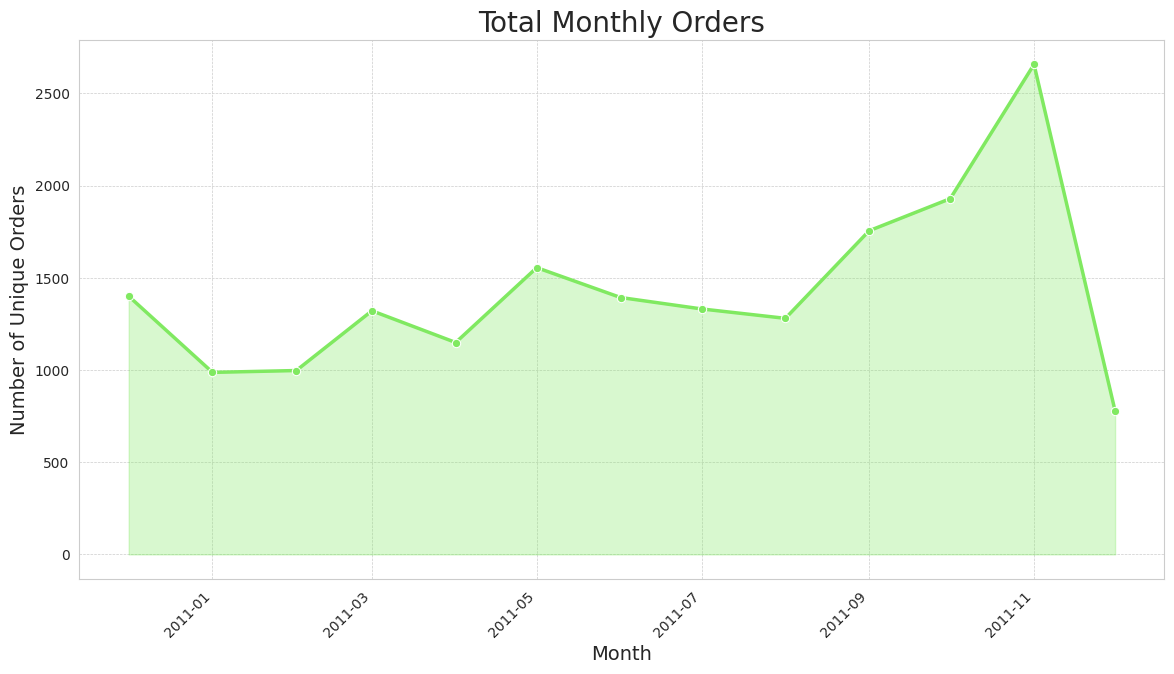

In [ ]:
# --- Calculate Monthly Order Count (if not already done) ---
monthly_orders = df_clean.groupby('YearMonth')['InvoiceNo'].nunique().reset_index()
monthly_orders['YearMonth'] = monthly_orders['YearMonth'].dt.to_timestamp()


# --- Visualize the Monthly Order Count Trend as an Area Chart ---
plt.figure(figsize=(14, 7))

# First, plot the line with markers
sns.lineplot(
    x='YearMonth',
    y='InvoiceNo',
    data=monthly_orders,
    marker='o',
    color='#80E961', # The main line color (green)
    linewidth=2.5
)

# --- THE NEW STEP: Add the shaded area ---
plt.fill_between(
    x=monthly_orders['YearMonth'],
    y1=monthly_orders['InvoiceNo'],
    color='#80E961', # Use the same color
    alpha=0.3       # Make it semi-transparent for a lighter shade
)

# --- Style the plot ---
plt.title('Total Monthly Orders', fontsize=20)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Unique Orders', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

In [ ]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12


## **Customer-Level Analysis**
* **Business Question:** Who are our most valuable customers, and do we follow the 80/20 rule (where a small percentage of customers drive the majority of revenue)?

--- Top Customer Insights ---
The Top 10 customers account for 17.26% of total revenue.


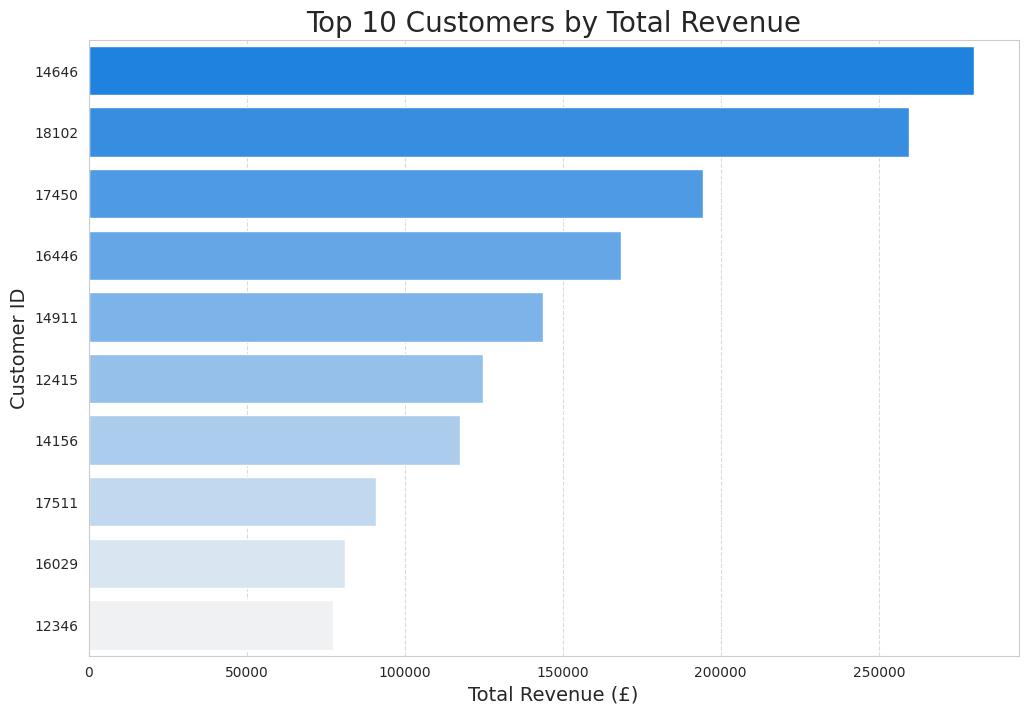

In [ ]:
# --- Calculate Total Revenue per Customer (same as before) ---
customer_revenue = df_clean.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False).reset_index()

# --- Calculate Contribution of Top Customers (same as before) ---
total_revenue = df_clean['Revenue'].sum()
top_10_revenue = customer_revenue.head(10)['Revenue'].sum()
top_10_percentage = (top_10_revenue / total_revenue) * 100

print(f"--- Top Customer Insights ---")
print(f"The Top 10 customers account for {top_10_percentage:.2f}% of total revenue.")


# --- Visualize the Top 10 Customers by Revenue (IMPROVED) ---
plt.figure(figsize=(12, 8))

# Create a vibrant, sequential blue palette
blue_palette = sns.light_palette("#0083FF", n_colors=10, reverse=True)

# Create the bar plot
sns.barplot(
    x='Revenue',
    y='CustomerID',
    data=customer_revenue.head(10),
    orient='h',
    palette=blue_palette,

    order=customer_revenue.head(10)['CustomerID']
)

# --- Style the plot ---
plt.title('Top 10 Customers by Total Revenue', fontsize=20)
plt.xlabel('Total Revenue (£)', fontsize=14)
plt.ylabel('Customer ID', fontsize=14)
# Convert CustomerID to string for plotting on y-axis
plt.yticks(plt.gca().get_yticks(), customer_revenue.head(10)['CustomerID'].astype(str))
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

* **Insight:** The business follows a classic Pareto Principle, with revenue heavily concentrated among a small group of elite customers.
* **Key Finding:** An extremely small portion of the customer base—just the **Top 10 customers** (less than 0.25% of all customers)—drives a massive **17.26%** of the company's total revenue.
* **Business Implication:** These VIP customers are critical assets. Identifying and nurturing this segment is the highest priority for ensuring stable revenue.

## **Analyzing Revenue by Product**
**Action**: We will group our data by Description (the product name), sum the Revenue for each, and then visualize the top 10 products in a horizontal bar chart.

**Reason**: This identifies the company's "hero products." Understanding which items are the main revenue drivers is essential for inventory management, marketing, and sales strategy.

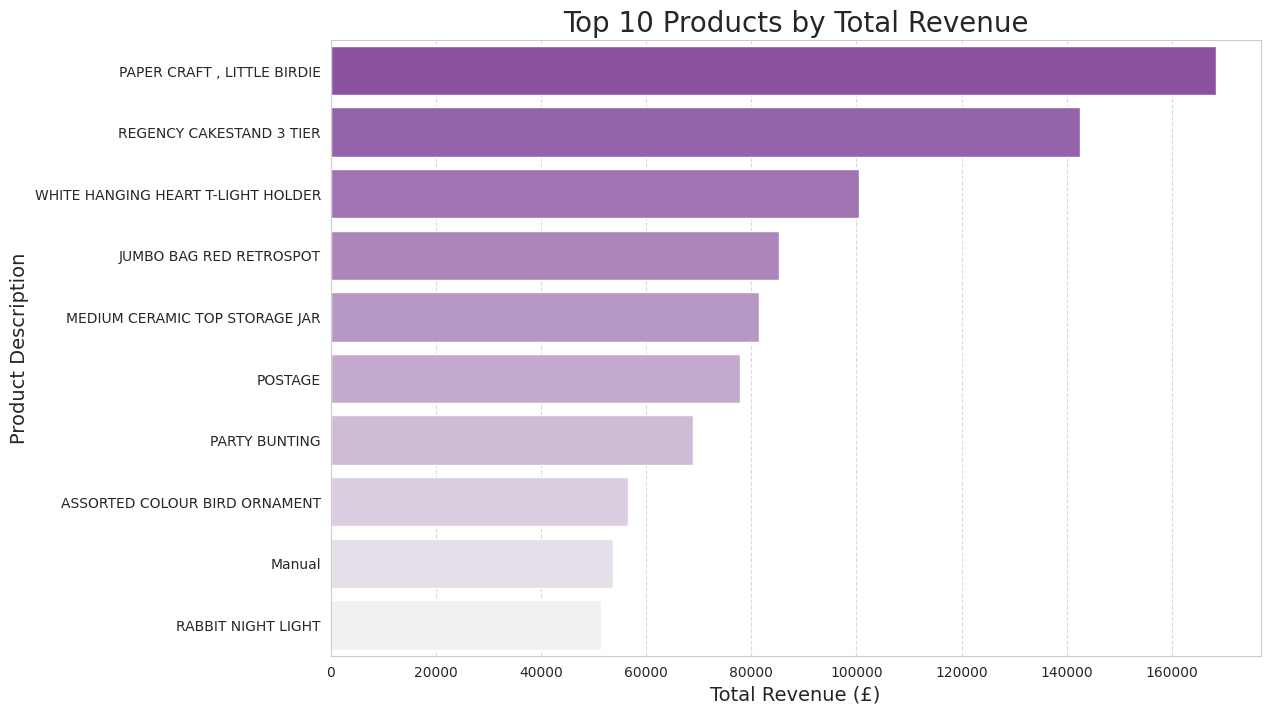

In [ ]:
# --- Calculate Total Revenue per Product (same as before) ---
product_revenue = df_clean.groupby('Description')['Revenue'].sum().sort_values(ascending=False).reset_index()


# --- Visualize the Top 10 Products by Revenue  ---
plt.figure(figsize=(12, 8))

# Create a vibrant, sequential purple palette
purple_palette = sns.light_palette("#8e44ad", n_colors=10, reverse=True) # A nice, rich purple

# Create the bar plot
sns.barplot(
    x='Revenue',
    y='Description',
    data=product_revenue.head(10),
    orient='h',
    palette=purple_palette,
    order=product_revenue.head(10)['Description']
)

# --- Style the plot ---
plt.title('Top 10 Products by Total Revenue', fontsize=20)
plt.xlabel('Total Revenue (£)', fontsize=14)
plt.ylabel('Product Description', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

* **Insight:** A small number of "hero products" are the primary drivers of revenue.
* **Key Findings:**
    1.  **Top Performers:** "PAPER CRAFT, LITTLE BIRDIE" and "REGENCY CAKESTAND 3 TIER" are the clear best-sellers.
    2.  **Dominant Categories:** The product list is dominated by home decor, party supplies, and crafts.
    3.  **Data Anomalies:** "POSTAGE" and "Manual" appear as top revenue sources, which is unusual and should be investigated as they are not standard products.

## **Analyzing Monthly Trends of Top Products**
**Action**: We will first identify our top 5 products. Then, we will pivot our data to get the monthly revenue for each of these products and plot them all on a single line chart.

**Reason**: This powerful visualization will show us if all top products follow the same seasonal trend or if some products are more popular at different times of the year. This is critical for seasonal marketing and inventory planning.

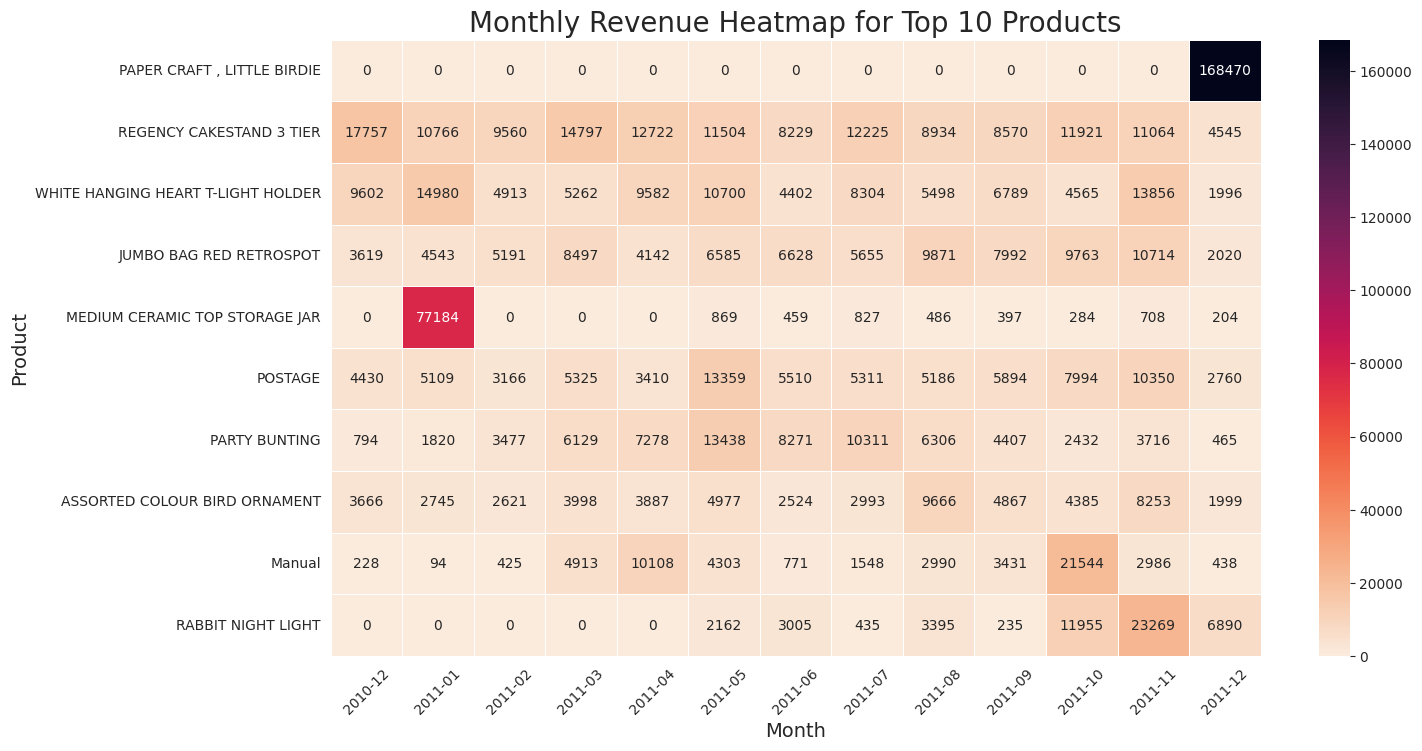

In [ ]:
# --- Identify the Top 10 Products ---
top_10_products = product_revenue.head(10)['Description'].tolist()

# --- Filter the main dataframe ---
df_top10 = df_clean[df_clean['Description'].isin(top_10_products)]

# --- Create a pivot table: Products as rows, Months as columns ---
product_pivot = df_top10.pivot_table(
    index='Description',
    columns='YearMonth',
    values='Revenue',
    aggfunc='sum'
).fillna(0) # Fill months with no sales with 0

# Reorder the pivot table to match the top 10 order
product_pivot = product_pivot.loc[top_10_products]


# --- Create the Heatmap ---
plt.figure(figsize=(15, 8))
sns.heatmap(
    product_pivot,
    annot=True,      # Show the revenue numbers in each cell
    fmt=".0f",       # Format numbers as integers (no decimals)
    cmap="rocket_r", # A nice, intuitive color map (darker = more revenue)
    linewidths=.5
)

# --- Style the plot ---
plt.title('Monthly Revenue Heatmap for Top 10 Products', fontsize=20)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Product', fontsize=14)
plt.xticks(rotation=45)

plt.show()

**Main Insight: No "One-Size-Fits-All" Strategy:** The top products exhibit vastly different sales patterns (seasonal, stable, anomalous), proving that a single inventory and marketing strategy is insufficient for the business.

* **New Product Launch:** `RABBIT NIGHT LIGHT` shows a clear growth trend from zero sales, indicating a successful product introduction mid-year.

* **Potential Stockout:** The `STORAGE JAR`'s massive January spike (£77k) followed by months of zero sales strongly signals a major stockout event, representing significant lost revenue.

* **Counter-Seasonal Demand:** `PARTY BUNTING` peaks in spring/summer, proving not all top products follow the holiday trend and thus require a separate marketing calendar.

* **Variable Forecasting:** Stable sellers like `REGENCY CAKESTAND` are easy to forecast, while more volatile products demand a more flexible inventory strategy.

#Handling Outliers

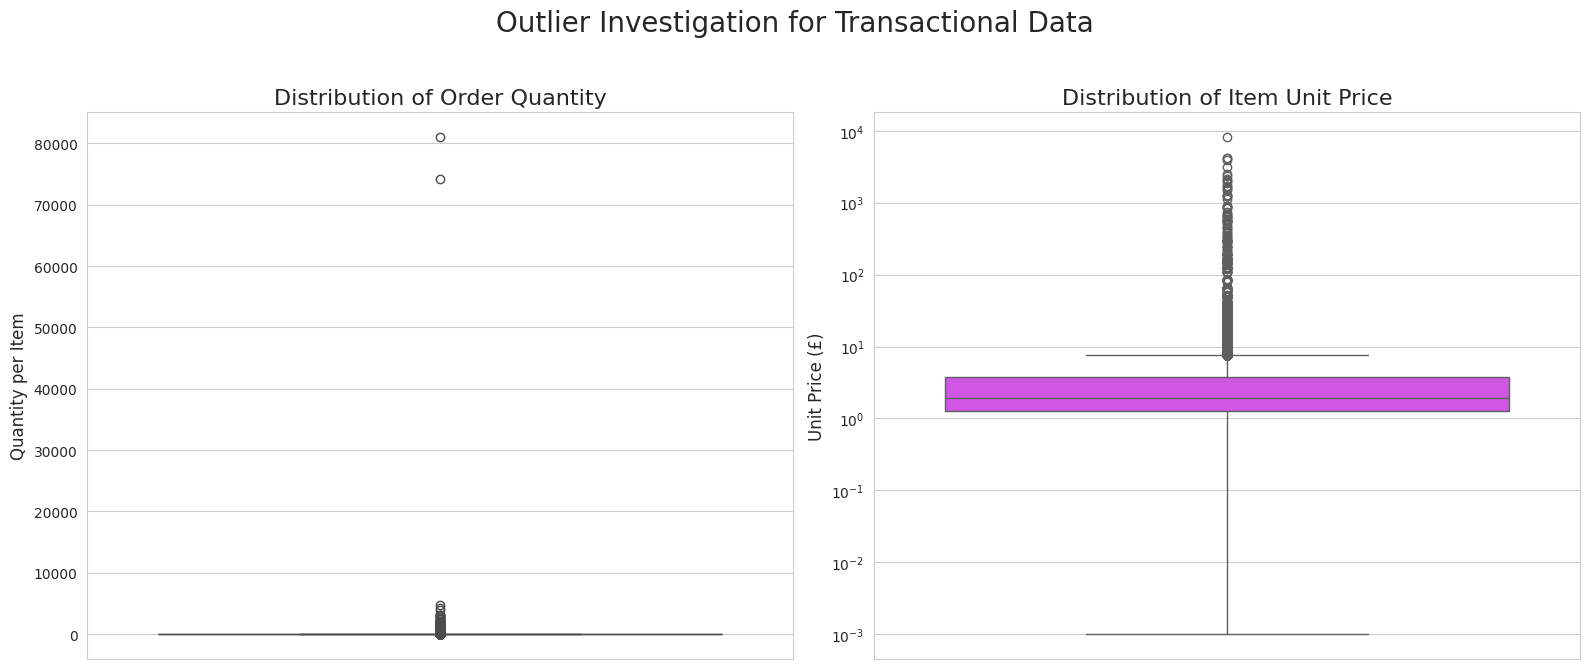

--- High-End Percentiles for Quantity ---
0.900       24.0
0.950       36.0
0.990      120.0
0.999      504.0
1.000    80995.0
Name: Quantity, dtype: float64

--- High-End Percentiles for UnitPrice ---
0.900       6.3500
0.950       8.5000
0.990      14.9500
0.999      41.8904
1.000    8142.7500
Name: UnitPrice, dtype: float64


In [ ]:
# --- Create a figure with 2 subplots ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Outlier Investigation for Transactional Data', fontsize=20)

# --- Plot 1: Quantity ---
sns.boxplot(y=df_clean['Quantity'], ax=axes[0], color='#FDA600') # Using an orange color
axes[0].set_title('Distribution of Order Quantity', fontsize=16)
axes[0].set_ylabel('Quantity per Item', fontsize=12)
# Using a log scale can help visualize skewed data, but for a first look, the standard scale shows the problem's magnitude
# axes[0].set_yscale('log')


# --- Plot 2: UnitPrice ---
sns.boxplot(y=df_clean['UnitPrice'], ax=axes[1], color='#E040FB') # Using the violet color
axes[1].set_title('Distribution of Item Unit Price', fontsize=16)
axes[1].set_ylabel('Unit Price (£)', fontsize=12)
# The price is extremely skewed, so a log scale is helpful here for visualization
axes[1].set_yscale('log')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- Also, let's look at the high-end percentiles to quantify the outliers ---
print("--- High-End Percentiles for Quantity ---")
print(df_clean['Quantity'].quantile([.90, .95, .99, .999, 1.0]))

print("\n--- High-End Percentiles for UnitPrice ---")
print(df_clean['UnitPrice'].quantile([.90, .95, .99, .999, 1.0]))

**Insight:** The raw transaction data is skewed by a small number of extreme, non-typical events (e.g., "mega-orders" or data errors), which hide the purchasing patterns of the average customer.

* **Key Findings:**
    1.  **"Mega-Orders" Identified:** The `Quantity` data reveals a massive gap between the 99.9th percentile (504 items) and the maximum value (80,995), indicating the presence of rare, non-standard wholesale or special orders.
    2.  **Anomalous Pricing:** Similarly, `UnitPrice` has an extreme maximum (£8,142) that is vastly different from the 99.9th percentile (~£42), suggesting these are not typical products but special charges or data errors.
    3.  **Strategic Implication:** To accurately understand and model the behavior of the typical customer, these extreme transactional outliers must be isolated from the main dataset.

In [ ]:
# --- Isolate Transactional Outliers using Percentile Capping ---

# Calculate the percentile thresholds from our df_clean DataFrame
quantity_threshold = df_clean['Quantity'].quantile(0.999)
price_threshold = df_clean['UnitPrice'].quantile(0.999)

print(f"Quantity 99.9th percentile (cutoff): {quantity_threshold:.2f}")
print(f"UnitPrice 99.9th percentile (cutoff): {price_threshold:.2f}")

# Create a new, final DataFrame by filtering out the transactional outliers
df_final_clean = df_clean[
    (df_clean['Quantity'] <= quantity_threshold) &
    (df_clean['UnitPrice'] <= price_threshold)
].copy()


# --- Final Verification ---
print(f"\nRows before transactional outlier removal: {df_clean.shape[0]}")
print(f"Rows in final, ultra-clean DataFrame: {df_final_clean.shape[0]}")
print(f"Total extreme transactions removed: {df_clean.shape[0] - df_final_clean.shape[0]}")

print("\n--- New Statistical Summary for 'df_final_clean' ---")
print(df_final_clean[['Quantity', 'UnitPrice']].describe())

Quantity 99.9th percentile (cutoff): 504.00
UnitPrice 99.9th percentile (cutoff): 41.89

Rows before transactional outlier removal: 397884
Rows in final, ultra-clean DataFrame: 397094
Total extreme transactions removed: 790

--- New Statistical Summary for 'df_final_clean' ---
            Quantity      UnitPrice
count  397094.000000  397094.000000
mean       11.693262       2.862951
std        25.847049       3.065609
min         1.000000       0.001000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max       504.000000      41.750000


#RFM Segmentation

* **Overall Strategy:** We will follow the classic RFM (Recency, Frequency, Monetary) methodology to segment our customers into actionable groups.

* **Methodology:**
    1.  **Calculate Raw RFM Values:** First, we will calculate the raw `Recency`, `Frequency`, and `Monetary` values for each customer from our clean transaction data.
    2.  **Assign Quantile Scores:** We will then convert these raw values into scores from 1-4 for each RFM dimension using quantiles. A higher score will always mean "better" (e.g., more frequent, more recent, higher spending).
    3.  **Create Overall Score:** We will sum the individual R, F, and M scores to create a final `RFM_Score` (from 3 to 12) for each customer.
    4.  **Define Final Segments:** Finally, we will use this `RFM_Score` to assign customers to intuitive, business-friendly segments like "Champions," "At Risk," and "Lost."

In [ ]:
# --- Define a reference date for Recency calculation ---
reference_date = df_final_clean['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Reference date for Recency calculation: {reference_date.date()}")


# --- Calculate Raw RFM Values ---
df_rfm = df_final_clean.groupby('CustomerID').agg(
    # Recency: Days from reference_date to the customer's last purchase
    Recency=('InvoiceDate', lambda date: (reference_date - date.max()).days),

    # Frequency: The count of unique invoices (transactions)
    Frequency=('InvoiceNo', 'nunique'),

    # Monetary: The sum of revenue for each customer
    Monetary=('Revenue', 'sum')
).reset_index()


# --- Final Verification ---
print(f"\nCreated RFM feature set with {df_rfm.shape[0]} unique customers.")

print("\n--- First 5 Rows of the RFM DataFrame ---")
print(df_rfm.head())

print("\n--- Statistical Summary of RFM Features ---")
print(df_rfm.describe())

Reference date for Recency calculation: 2011-12-10

Created RFM feature set with 4319 unique customers.

--- First 5 Rows of the RFM DataFrame ---
   CustomerID  Recency  Frequency  Monetary
0       12347        2          7   4310.00
1       12348       75          4   1797.24
2       12349       19          1   1457.55
3       12350      310          1    334.40
4       12352       36          7   1665.74

--- Statistical Summary of RFM Features ---
         CustomerID      Recency    Frequency       Monetary
count   4319.000000  4319.000000  4319.000000    4319.000000
mean   15298.642741    92.516092     4.253068    1883.821888
std     1721.412606    99.962689     7.626870    7665.933420
min    12347.000000     1.000000     1.000000       2.900000
25%    13812.500000    18.000000     1.000000     302.410000
50%    15297.000000    51.000000     2.000000     663.650000
75%    16778.500000   142.500000     5.000000    1626.550000
max    18287.000000   374.000000   206.000000  265207.26

* `Recency` = 310 means that customer 12350 made their last purchase 310 days ago.

* `Frequency` = 7 means that customer 12347 made 7 separate purchases.

* `Monetary` = 4310.00 means that customer 12347 spent a total of £4,310.00.

### RFM Scoring - Step 1: Recency

* **Objective:** To assign a Recency score (1-4) to each customer.
* **First Step:** We will use the Elbow Method to find the optimal number of clusters for our `Recency` data.

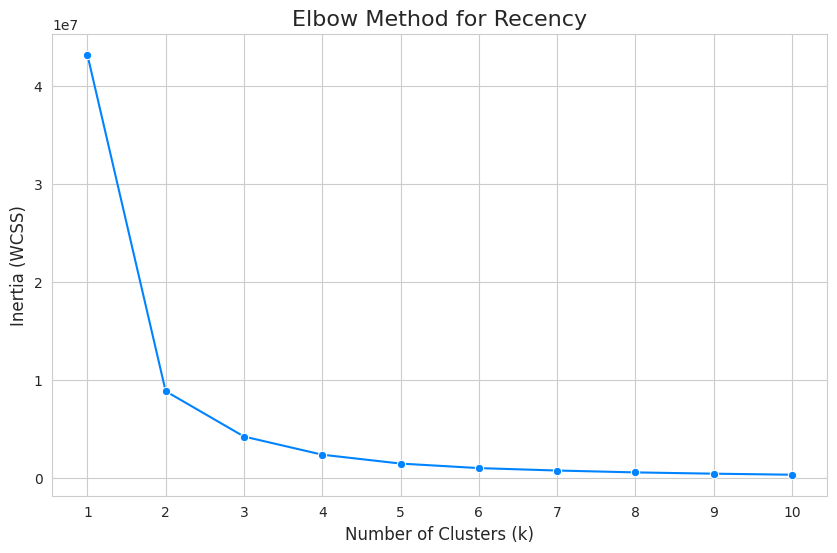

In [ ]:
# --- Find the optimal number of clusters for Recency ---
# We'll use a temporary dataframe with just the Recency column
df_recency = df_rfm[['Recency']]

# WCSS = Within-Cluster Sum of Squares (a.k.a. inertia or SSE)
wcss = {}

# We will test k from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_recency)
    wcss[k] = kmeans.inertia_

# --- Plot the Elbow Method graph ---
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(wcss.keys()), y=list(wcss.values()), marker='o', color='#0083FF') # Blue line

plt.title('Elbow Method for Recency', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

k = 4


---


* Apply K-Means and logically order the clusters.
* **Actions:**
    1.  Run K-Means with `k=4` to assign initial `RecencyCluster` labels.
    2.  Re-order these cluster labels so that a higher score always means a better Recency (more recent).

In [ ]:
# --- Apply K-Means with k=4 ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_rfm['RecencyCluster'] = kmeans.fit_predict(df_rfm[['Recency']])


# --- Define the ordering function (as seen in the video) ---
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    """
    Orders the cluster labels based on the mean of a target field.
    A higher score is always better.
    For Recency, ascending=False (lower recency is better).
    For Frequency/Monetary, ascending=True (higher value is better).
    """
    # Calculate the mean of the target field for each cluster
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    # Sort the clusters by their mean value
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    # Create a new 'index' column that will be our new ordered score (0-3)
    df_new['index'] = df_new.index

    # Merge this back to the original dataframe
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    # Drop the old, unordered cluster column
    df_final = df_final.drop([cluster_field_name], axis=1)
    # Rename the 'index' column to our final score name
    df_final = df_final.rename(columns={"index": cluster_field_name})

    return df_final


# --- Order the Recency Clusters ---
# We use ascending=False because a lower Recency value is better.
df_rfm_ordered = order_cluster('RecencyCluster', 'Recency', df_rfm, False)

# Let's rename the column to R_Score for clarity
df_rfm_ordered.rename(columns={'RecencyCluster': 'R_Score'}, inplace=True)


# --- Final Verification ---
print("Recency scores assigned and ordered successfully.")
print("\n--- First 5 Rows with Ordered R_Score ---")
print(df_rfm_ordered.head())

print("\n--- Average Recency per Ordered Score ---")
# A higher score should now correspond to a lower average Recency
print(df_rfm_ordered.groupby('R_Score')['Recency'].mean())

Recency scores assigned and ordered successfully.

--- First 5 Rows with Ordered R_Score ---
   CustomerID  Recency  Frequency  Monetary  R_Score
0       12347        2          7   4310.00        3
1       12348       75          4   1797.24        2
2       12349       19          1   1457.55        3
3       12350      310          1    334.40        0
4       12352       36          7   1665.74        3

--- Average Recency per Ordered Score ---
R_Score
0    308.795960
1    192.699834
2     83.360499
3     20.009183
Name: Recency, dtype: float64


* `R_Score = 3` (the best score) corresponds to the lowest average Recency (20 days).

* `R_Score = 0` (the worst score) corresponds to the highest average Recency (308 days).

### RFM Scoring - Step 2: Frequency

* **Objective:** To assign a Frequency score (0-3) to each customer.
* **First Step:** We will use the Elbow Method to find the optimal number of clusters for our `Frequency` data.

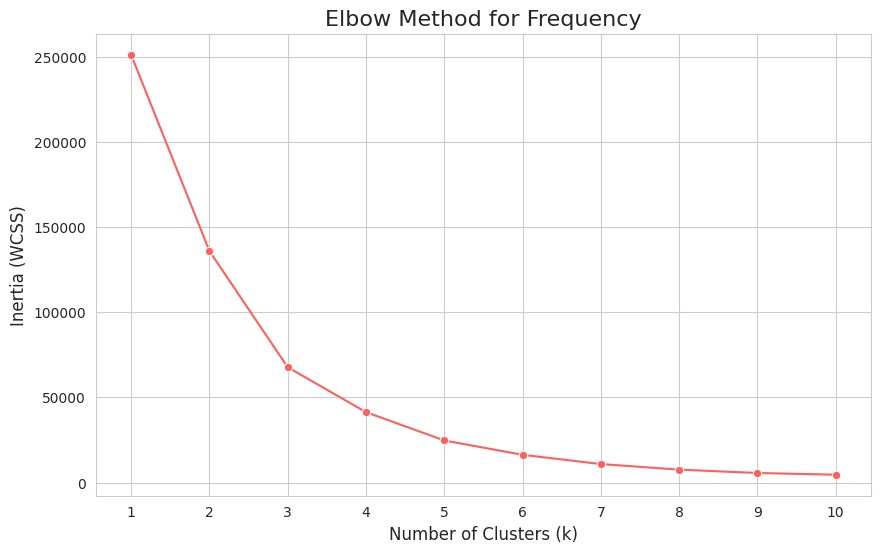

In [ ]:
# --- Find the optimal number of clusters for Frequency ---
# We'll use a temporary dataframe with just the Frequency column
df_frequency = df_rfm_ordered[['Frequency']]

wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_frequency)
    wcss[k] = kmeans.inertia_

# --- Plot the Elbow Method graph ---
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(wcss.keys()), y=list(wcss.values()), marker='o', color='#FF5F5F') # Pink/Coral line

plt.title('Elbow Method for Frequency', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

* Apply K-Means and logically order the clusters for Frequency.
* **Action:**
    1.  Run K-Means with `k=4` to assign initial `FrequencyCluster` labels.
    2.  Re-order these cluster labels so that a higher score always means better Frequency (more frequent).

In [ ]:
# --- Apply K-Means with k=4 ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_rfm_ordered['FrequencyCluster'] = kmeans.fit_predict(df_rfm_ordered[['Frequency']])


# --- Order the Frequency Clusters ---
# We use ascending=True because a HIGHER Frequency value is better.
df_rfm_ordered = order_cluster('FrequencyCluster', 'Frequency', df_rfm_ordered, True)

# Let's rename the column to F_Score for clarity
df_rfm_ordered.rename(columns={'FrequencyCluster': 'F_Score'}, inplace=True)


# --- Final Verification ---
print("Frequency scores assigned and ordered successfully.")
print("\n--- First 5 Rows with Ordered F_Score ---")
print(df_rfm_ordered.head())

print("\n--- Average Frequency per Ordered Score ---")
# A higher score should now correspond to a HIGHER average Frequency
print(df_rfm_ordered.groupby('F_Score')['Frequency'].mean())

Frequency scores assigned and ordered successfully.

--- First 5 Rows with Ordered F_Score ---
   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score
0       12347        2          7   4310.00        3        0
1       12348       75          4   1797.24        2        0
2       12349       19          1   1457.55        3        0
3       12350      310          1    334.40        0        0
4       12352       36          7   1665.74        3        0

--- Average Frequency per Ordered Score ---
F_Score
0      2.500531
1     12.743137
2     45.952381
3    176.000000
Name: Frequency, dtype: float64


* `F_Score = 3` (the best score) corresponds to the highest average Frequency (176 purchases).

* `F_Score = 0` (the worst score) corresponds to the lowest average Frequency (2.5 purchases).

### RFM Scoring - Step 3: Monetary

* **Objective:** To assign a Monetary score (0-3) to each customer.
* **First Step:** We will use the Elbow Method to find the optimal number of clusters for our `Monetary` data.

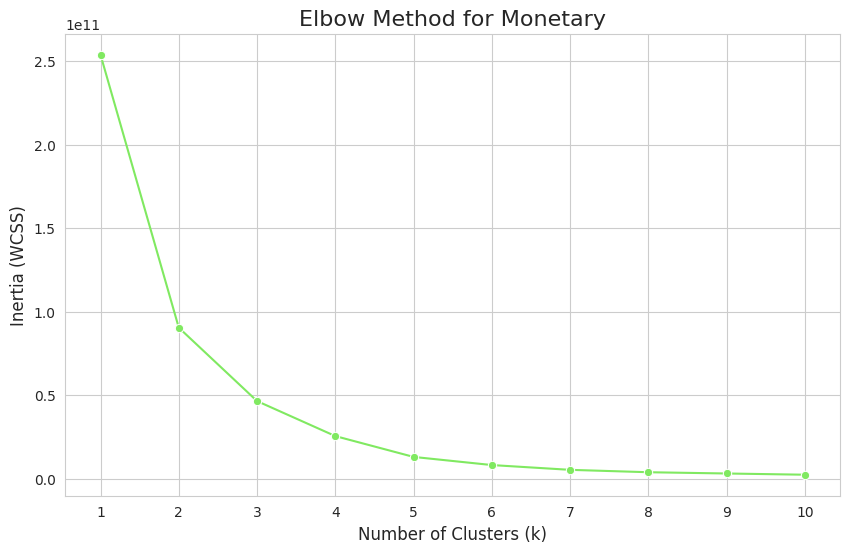

In [ ]:
# --- Find the optimal number of clusters for Monetary ---
# We'll use a temporary dataframe with just the Monetary column
df_monetary = df_rfm_ordered[['Monetary']]

wcss = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_monetary)
    wcss[k] = kmeans.inertia_

# --- Plot the Elbow Method graph ---
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(wcss.keys()), y=list(wcss.values()), marker='o', color='#80E961') # Green line

plt.title('Elbow Method for Monetary', fontsize=16)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (WCSS)', fontsize=12)
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

* Apply K-Means and logically order the clusters for Monetary.
* **Action:**
    1.  Run K-Means with `k=4` to assign initial `MonetaryCluster` labels.
    2.  Re-order these cluster labels so that a higher score always means better Monetary value (higher spending).

In [ ]:
# --- Apply K-Means with k=4 ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_rfm_ordered['MonetaryCluster'] = kmeans.fit_predict(df_rfm_ordered[['Monetary']])


# --- Order the Monetary Clusters ---
# We use ascending=True because a HIGHER Monetary value is better.
df_rfm_ordered = order_cluster('MonetaryCluster', 'Monetary', df_rfm_ordered, True)

# Let's rename the column to M_Score for clarity
df_rfm_ordered.rename(columns={'MonetaryCluster': 'M_Score'}, inplace=True)


# --- Final Verification ---
print("Monetary scores assigned and ordered successfully.")
print("\n--- First 5 Rows with Final Scores ---")
print(df_rfm_ordered.head())

print("\n--- Average Monetary value per Ordered Score ---")
# A higher score should now correspond to a HIGHER average Monetary value
print(df_rfm_ordered.groupby('M_Score')['Monetary'].mean())

Monetary scores assigned and ordered successfully.

--- First 5 Rows with Final Scores ---
   CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score
0       12347        2          7   4310.00        3        0        0
1       12348       75          4   1797.24        2        0        0
2       12349       19          1   1457.55        3        0        0
3       12350      310          1    334.40        0        0        0
4       12352       36          7   1665.74        3        0        0

--- Average Monetary value per Ordered Score ---
M_Score
0      1389.914099
1     37987.450345
2    115748.006000
3    251424.280000
Name: Monetary, dtype: float64


### Creating Final RFM Score & Business Segments

* **Objective:** To combine the individual scores into a final, holistic `RFM_Score` and then create actionable, business-friendly customer segments.
* **Actions:**
    1.  Create a final `RFM_Score` by summing the R, F, and M scores.
    2.  Define and apply rules to group customers into segments like "Champions," "At Risk," etc.

In [ ]:
# --- Create the RFM_Score (sum) ---
# We sum the integer scores (which are 0-3, so the total will be 0-9)
df_rfm_ordered['RFM_Score'] = df_rfm_ordered[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)


# --- Define Segments based on the Overall Score ---
# These segments are defined based on common RFM analysis best practices.
def assign_segment(score):
    if score >= 8:
        return 'Champions' # Scores 8, 9 - Best Customers
    elif score >= 6:
        return 'Potentially Loyal' # Scores 6, 7
    elif score >= 4:
        return 'At Risk' # Scores 4, 5
    elif score >= 2:
        return "Can't Lose" # Scores 2, 3
    else:
        return 'Lost' # Scores 0, 1

# Apply the function to create the final Segment column
df_rfm_ordered['Segment'] = df_rfm_ordered['RFM_Score'].apply(assign_segment)


# --- Final Verification ---
print("Final RFM Score and Segments created successfully.")
print("\n--- First 5 Rows with Final Segments ---")
# Display relevant columns to see the result
print(df_rfm_ordered[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Segment']].head())

print("\n--- Number of Customers in Each Segment ---")
print(df_rfm_ordered['Segment'].value_counts())

Final RFM Score and Segments created successfully.

--- First 5 Rows with Final Segments ---
   CustomerID  Recency  Frequency  Monetary  RFM_Score     Segment
0       12347        2          7   4310.00          3  Can't Lose
1       12348       75          4   1797.24          2  Can't Lose
2       12349       19          1   1457.55          3  Can't Lose
3       12350      310          1    334.40          0        Lost
4       12352       36          7   1665.74          3  Can't Lose

--- Number of Customers in Each Segment ---
Segment
Can't Lose           2721
Lost                 1090
At Risk               484
Potentially Loyal      21
Champions               3
Name: count, dtype: int64


In [ ]:
import plotly.express as px

# --- Prepare data for the treemap ---
# Get the counts of customers in each segment
segment_counts = df_rfm_ordered['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']


# --- Create the Treemap ---
fig = px.treemap(
    segment_counts,
    path=['Segment'], # The hierarchy for the treemap
    values='Count',      # The size of the rectangles
    color='Segment',     # Color each segment differently
    color_discrete_map={ # Assign specific, nice colors to our segments
        'Champions': '#80E961',         # Green
        'Potentially Loyal': '#a2cffe', # Light Blue
        'At Risk': '#FDA600',           # Orange
        "Can't Lose": '#ff9999',        # Pink/Coral
        'Lost': '#E040FB'               # Violet
    },
    title='Distribution of RFM Customer Segments'
)

# --- Style the plot ---
fig.update_layout(
    title_font_size=22,
    font=dict(size=14)
)
fig.update_traces(textinfo='label+percent root') # Show segment name and percentage

# Show the interactive plot
fig.show()

### RFM Scoring using Quantiles (Direct Method)

* **Strategic Pivot:** We are now using the more direct and robust **Quantile-based scoring method**.
* **Method:** We will slice the ranked customers for each RFM metric into four equal groups (quartiles) and assign a score from 1 to 4. A score of 4 always represents the best-in-class customers.

In [ ]:
# --- Create a new DataFrame for the scored data ---
df_rfm_scored = df_rfm.copy()


# --- 1. Calculate Quantiles on the Correct Columns ---
quantiles = df_rfm[['Recency', 'Frequency', 'Monetary']].quantile(q=[0.25, 0.50, 0.75])
quantiles = quantiles.to_dict()


# --- 2. Define the Scoring Functions (same as before) ---
def r_score(x, p, d):
    if x <= d[p][0.25]: return 4
    elif x <= d[p][0.50]: return 3
    elif x <= d[p][0.75]: return 2
    else: return 1

def fm_score(x, p, d):
    if x <= d[p][0.25]: return 1
    elif x <= d[p][0.50]: return 2
    elif x <= d[p][0.75]: return 3
    else: return 4


# --- 3. Apply the functions to create the score columns in the NEW DataFrame ---
df_rfm_scored['R_Score'] = df_rfm_scored['Recency'].apply(r_score, args=('Recency', quantiles))
df_rfm_scored['F_Score'] = df_rfm_scored['Frequency'].apply(fm_score, args=('Frequency', quantiles))
df_rfm_scored['M_Score'] = df_rfm_scored['Monetary'].apply(fm_score, args=('Monetary', quantiles))


# --- Final Verification ---
print("RFM scores assigned successfully to the new 'df_rfm_scored' DataFrame.")
print("\n--- First 5 Rows of the Scored DataFrame ---")
print(df_rfm_scored.head())

RFM scores assigned successfully to the new 'df_rfm_scored' DataFrame.

--- First 5 Rows of the Scored DataFrame ---
   CustomerID  Recency  Frequency  Monetary  RecencyCluster  R_Score  F_Score  \
0       12347        2          7   4310.00               3        4        4   
1       12348       75          4   1797.24               0        2        3   
2       12349       19          1   1457.55               3        3        1   
3       12350      310          1    334.40               1        1        1   
4       12352       36          7   1665.74               3        3        4   

   M_Score  
0        4  
1        4  
2        3  
3        2  
4        4  


In [ ]:
# --- Create the RFM_Score (sum) on the CORRECT DataFrame ---
# We sum the integer scores (which are 1-4, so the total will be 3-12)
df_rfm_scored['RFM_Score'] = df_rfm_scored[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)


# --- Define Segments based on the Overall Score ---
# These segments are defined based on common RFM analysis best practices.
def assign_segment(score):
    if score >= 9:
        return 'Champions' # Best Customers (Scores 9, 10, 11, 12)
    elif score >= 6:
        return 'Potentially Loyal' # (Scores 6, 7, 8)
    elif score >= 5:
        return 'At Risk' # (Score 5)
    elif score >= 4:
        return "Can't Lose" # (Score 4)
    else:
        return 'Lost' # (Score 3)

# Apply the function to create the final Segment column in the CORRECT DataFrame
df_rfm_scored['Segment'] = df_rfm_scored['RFM_Score'].apply(assign_segment)


# --- Final Verification ---
print("Final RFM Score and Segments created successfully.")
print("\n--- First 5 Rows with Final Segments ---")
# Display relevant columns to see the result
print(df_rfm_scored[['CustomerID', 'RFM_Score', 'Segment']].head())

print("\n--- Number of Customers in Each Segment ---")
print(df_rfm_scored['Segment'].value_counts())

Final RFM Score and Segments created successfully.

--- First 5 Rows with Final Segments ---
   CustomerID  RFM_Score            Segment
0       12347         12          Champions
1       12348          9          Champions
2       12349          7  Potentially Loyal
3       12350          4         Can't Lose
4       12352         11          Champions

--- Number of Customers in Each Segment ---
Segment
Champions            1619
Potentially Loyal    1292
Can't Lose            498
At Risk               469
Lost                  441
Name: count, dtype: int64


In [ ]:
import plotly.express as px

# --- Prepare data for the treemap from the CORRECT DataFrame ---
# THIS IS THE FIX: We use 'df_rfm_scored'
segment_counts = df_rfm_scored['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']


# --- Create the Treemap ---
fig = px.treemap(
    segment_counts,
    path=['Segment'], # The hierarchy for the treemap
    values='Count',      # The size of the rectangles
    color='Segment',     # Color each segment differently
    color_discrete_map={ # Assign specific, nice colors to our segments
        'Champions': '#80E961',         # Green
        'Potentially Loyal': '#a2cffe', # Light Blue
        'At Risk': '#FDA600',           # Orange
        "Can't Lose": '#ff9999',        # Pink/Coral
        'Lost': '#E040FB'               # Violet
    },
    title='Distribution of RFM Customer Segments'
)

# --- Style the plot ---
fig.update_layout(
    title_font_size=22,
    font=dict(size=14)
)
fig.update_traces(textinfo='label+percent root') # Show segment name and percentage

# Show the interactive plot
fig.show()

# 5. Designing the Campaign Blueprint for "Champions"

### 5.1. Deep-Dive Analysis of the "Champions" Cohort

* **Objective:** To understand the specific purchasing habits of our best customers to inform our campaign strategy.
* **Key Question:** What specific products do our "Champions" love the most?

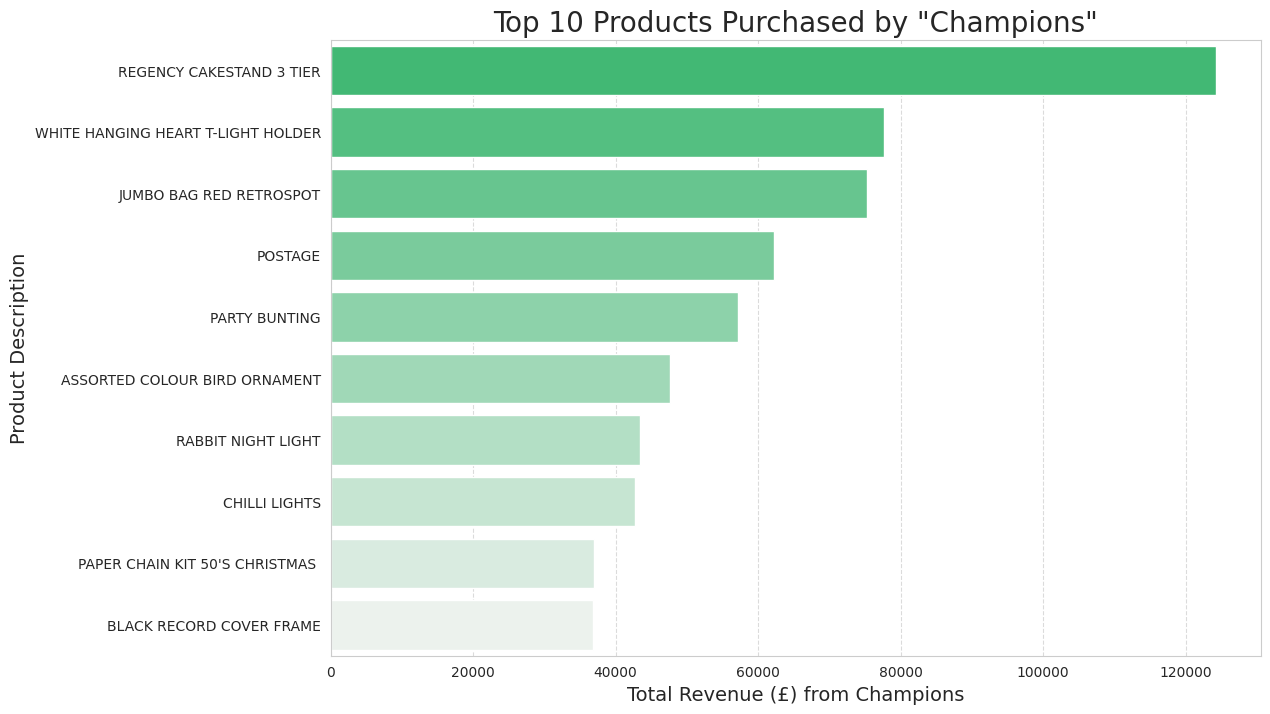

In [ ]:
# --- Isolate the "Champions" Cohort ---
df_champions = df_rfm_scored[df_rfm_scored['Segment'] == 'Champions']

# We need to merge this back with the original transaction data to see what they bought
champions_transactions = df_clean[df_clean['CustomerID'].isin(df_champions['CustomerID'])]


# --- Calculate Top 10 Products for Champions ---
champions_product_revenue = champions_transactions.groupby('Description')['Revenue'].sum().sort_values(ascending=False).reset_index()


# --- Visualize the Top 10 Products for Champions ---
plt.figure(figsize=(12, 8))

# Create a vibrant, sequential green palette for our champions
green_palette = sns.light_palette("#2ecc71", n_colors=10, reverse=True) # A rich green

sns.barplot(
    x='Revenue',
    y='Description',
    data=champions_product_revenue.head(10),
    orient='h',
    palette=green_palette,
    order=champions_product_revenue.head(10)['Description']
)

# --- Style the plot ---
plt.title('Top 10 Products Purchased by "Champions"', fontsize=20)
plt.xlabel('Total Revenue (£) from Champions', fontsize=14)
plt.ylabel('Product Description', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

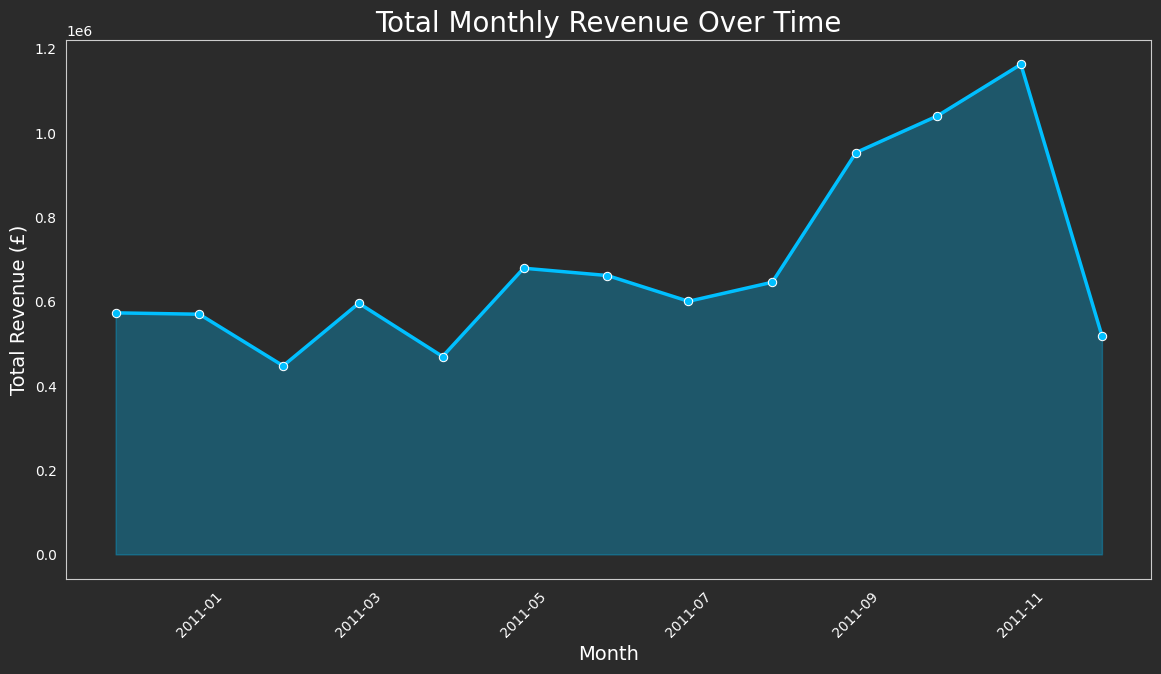

In [ ]:
# --- Calculate Monthly Revenue (if not already done) ---
df_clean['YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M')
monthly_revenue = df_clean.groupby('YearMonth')['Revenue'].sum().reset_index()
monthly_revenue['YearMonth'] = monthly_revenue['YearMonth'].dt.to_timestamp()


# --- Visualize the Monthly Revenue Trend as an Area Chart ---
fig, ax = plt.subplots(figsize=(14, 7), facecolor='#2B2B2B')  # Entire figure background black
ax.set_facecolor('#2B2B2B')  # Plot area background black

# Plot the line with markers
sns.lineplot(
    x='YearMonth',
    y='Revenue',
    data=monthly_revenue,
    marker='o',
    color='#00BFFF',  # Bright blue line
    linewidth=2.5,
    ax=ax
)

# Fill the area under the line
ax.fill_between(
    x=monthly_revenue['YearMonth'],
    y1=monthly_revenue['Revenue'],
    color='#00BFFF',
    alpha=0.3
)

# --- Style the plot ---
ax.set_title('Total Monthly Revenue Over Time', fontsize=20, color='white')
ax.set_xlabel('Month', fontsize=14, color='white')
ax.set_ylabel('Total Revenue (£)', fontsize=14, color='white')
ax.tick_params(axis='x', colors='white', rotation=45)
ax.tick_params(axis='y', colors='white')

# Remove grid lines
ax.grid(False)

# Show the plot
plt.show()


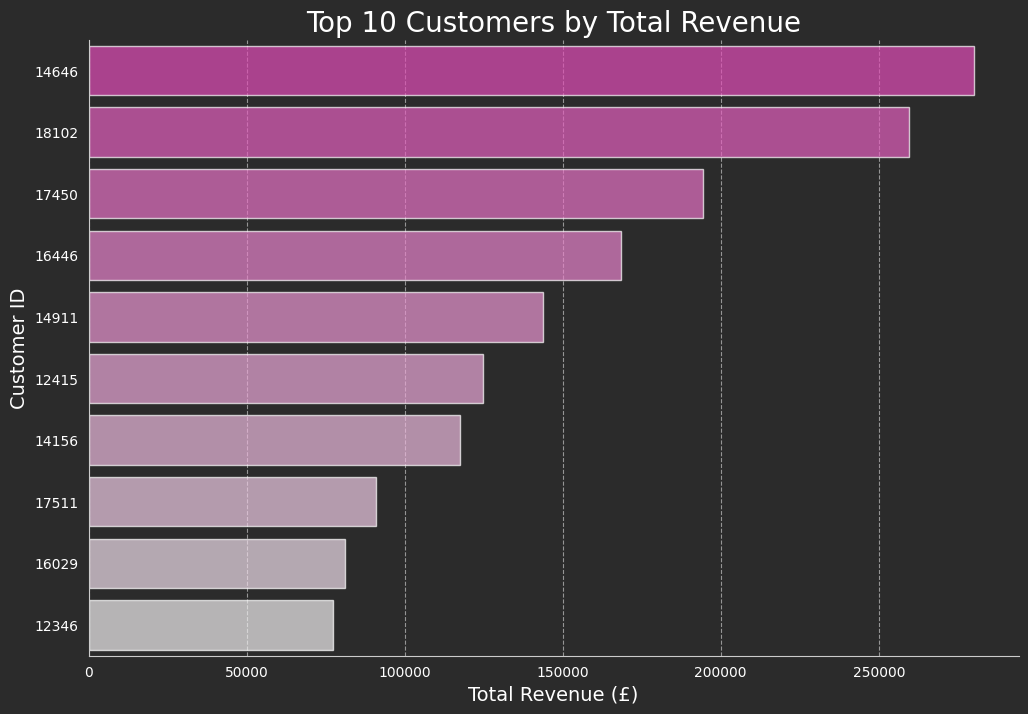

In [ ]:
# --- Visualize the Top 10 Customers by Revenue (Dark Theme, Neon Pink Bars) ---
plt.figure(figsize=(12, 8), facecolor='#2B2B2B')  # Figure background

# Neon pink palette
neon_pink_palette = sns.light_palette("#FA34C2", n_colors=10, reverse=True)

# Create the bar plot
ax = sns.barplot(
    x='Revenue',
    y='CustomerID',
    data=customer_revenue.head(10),
    orient='h',
    palette=neon_pink_palette,
    order=customer_revenue.head(10)['CustomerID']
)

# Make bars translucent
for bar in ax.patches:
    bar.set_alpha(0.7)  # Adjust transparency

# Style the plot
ax.set_facecolor('#2B2B2B')
plt.title('Top 10 Customers by Total Revenue', fontsize=20, color='white')
plt.xlabel('Total Revenue (£)', fontsize=14, color='white')
plt.ylabel('Customer ID', fontsize=14, color='white')

plt.yticks(plt.gca().get_yticks(), customer_revenue.head(10)['CustomerID'].astype(str), color='white')
plt.xticks(color='white')

# Subtle grid
ax.grid(axis='x', linestyle='--', alpha=0.5, color='white')

# Remove top and right spines
sns.despine(left=False, bottom=False)

plt.show()


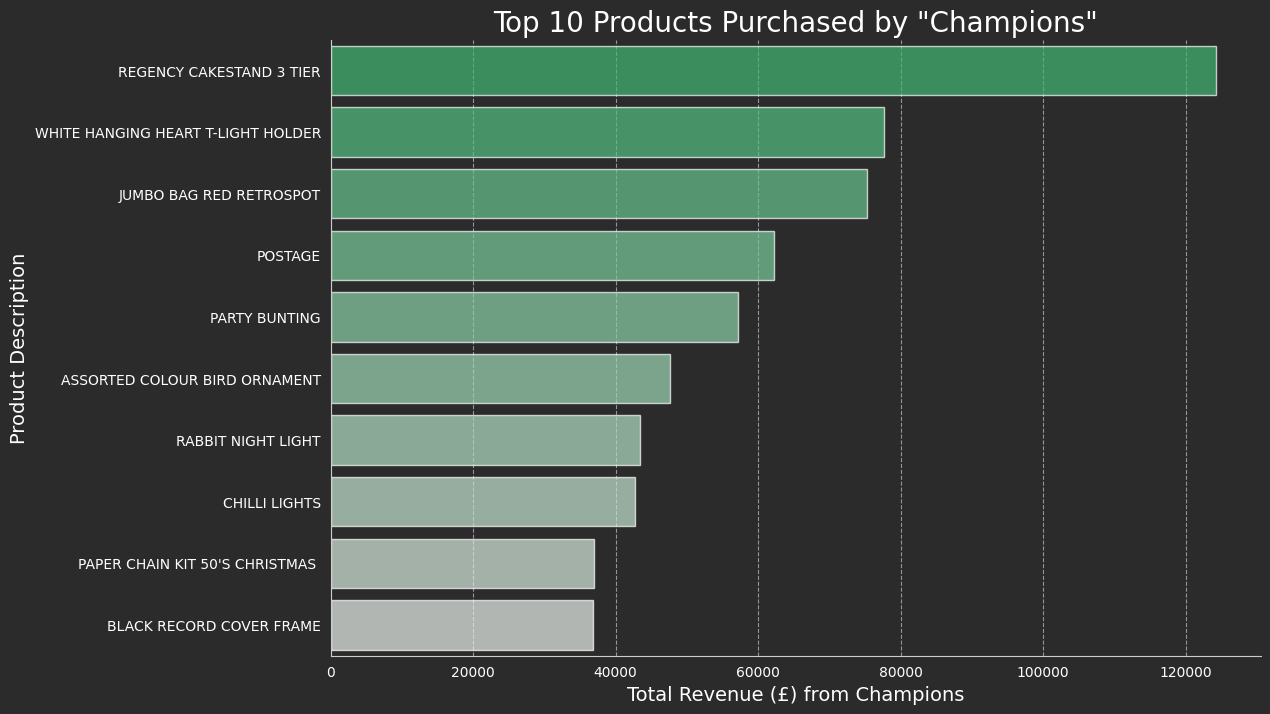

In [ ]:
# --- Visualize the Top 10 Products for "Champions" (Dark Theme, Translucent Green) ---
plt.figure(figsize=(12, 8), facecolor='#2B2B2B')  # Figure background

# Vibrant, slightly translucent green palette
green_palette = sns.light_palette("#2ECC71", n_colors=10, reverse=True)

# Create the bar plot
ax = sns.barplot(
    x='Revenue',
    y='Description',
    data=champions_product_revenue.head(10),
    orient='h',
    palette=green_palette,
    order=champions_product_revenue.head(10)['Description']
)

# Make bars translucent
for bar in ax.patches:
    bar.set_alpha(0.7)  # Adjust transparency

# Style the plot
ax.set_facecolor('#2B2B2B')  # Dark axes background
plt.title('Top 10 Products Purchased by "Champions"', fontsize=20, color='white')
plt.xlabel('Total Revenue (£) from Champions', fontsize=14, color='white')
plt.ylabel('Product Description', fontsize=14, color='white')

# Set y-tick and x-tick labels to white
plt.yticks(plt.gca().get_yticks(), champions_product_revenue.head(10)['Description'], color='white')
plt.xticks(color='white')

# Subtle grid
ax.grid(axis='x', linestyle='--', alpha=0.5, color='white')

# Remove top and right spines
sns.despine(left=False, bottom=False)

plt.show()
